## Super resolution

In [ ]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [ ]:
from torchvision.models import vgg16_bn

In [ ]:
torch.cuda.set_device(2)

In [ ]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [ ]:
il = ImageItemList.from_folder(path_hr)

In [ ]:
def resize_one(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img,64,use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [ ]:
# to create smaller images, uncomment the next line when you run this the first time
# parallel(resize_one, il.items)

In [ ]:
# bs,size=16,256
bs,size=32,160
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)
data = (src.label_from_func(lambda x: path_hr/x.name)
       .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
       .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

data.c = 3

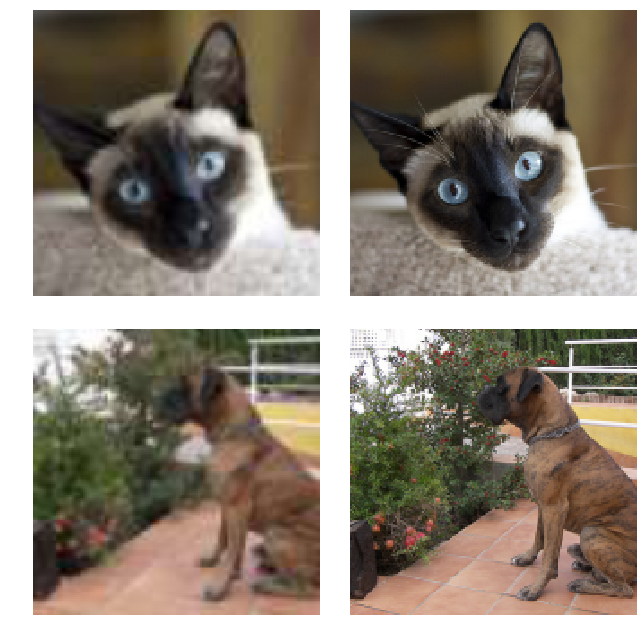

In [ ]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [ ]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [ ]:
t = data.valid_ds[0][1].data[None]; t.shape

torch.Size([1, 3, 160, 160])

In [ ]:
edge = F.conv2d(t, k)

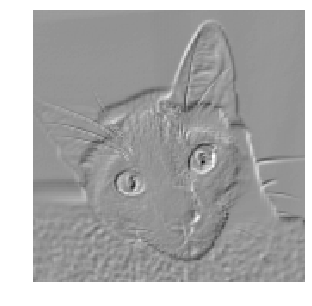

In [ ]:
show_image(edge[0], figsize=(5,5));

In [ ]:
base_loss = F.l1_loss
k = k.cuda()

In [ ]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['L1      ','edge    '] + [f'feat_{i}  ' for i in range(len(layer_ids))]

    def make_feature(self, bs, o, clone=False):
        feat = o.view(bs, -1)
        return feat.clone() if clone else feat
    
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [self.make_feature(x.shape[0], o, clone) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        px_loss   = base_loss(input,target)
        edge_loss = base_loss(F.conv2d(target, k), F.conv2d(input, k))
        self.feat_losses = [px_loss,edge_loss]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [ ]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,5,5])

In [ ]:
def get_preds():
    x,y=learn.data.one_batch(DatasetType.Valid, True,True)
    preds = data.denorm(learn.pred_batch(DatasetType.Valid).detach())
    return x,y,preds

def show_pred(i=0):
    _,axes = plt.subplots(1,3, figsize=(15,5))
    show_image(x[i], axes[0])
    show_image(preds[i], axes[1])
    show_image(y[i], axes[2]);

## Train

In [ ]:
wd = 1e-3

In [ ]:
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, all_wn=True, blur=True)

In [ ]:
gc.collect();

In [ ]:
learn.data = data
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


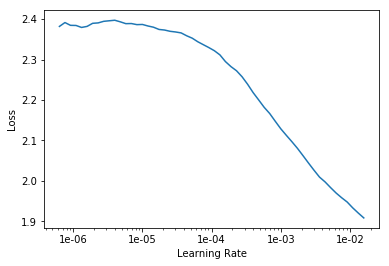

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-3

In [ ]:
#size 160
learn.fit_one_cycle(10, slice(lr*10), pct_start=0.9)

Total time: 12:22
epoch  train_loss  valid_loss  L1        edge      feat_0    feat_1    feat_2  
1      1.426100    1.369868    0.206474  0.238908  0.258134  0.114819  0.551533  (01:17)
2      1.366286    1.280436    0.163899  0.230229  0.248151  0.110166  0.527991  (01:14)
3      1.384681    1.325979    0.202550  0.232032  0.248298  0.111030  0.532069  (01:14)
4      1.379221    1.343543    0.205343  0.235489  0.249795  0.112715  0.540202  (01:13)
5      1.366817    1.338012    0.196089  0.235982  0.251826  0.113962  0.540153  (01:13)
6      1.369667    1.292056    0.172351  0.235050  0.244021  0.110791  0.529844  (01:14)
7      1.368942    1.315681    0.192384  0.237009  0.247452  0.110735  0.528102  (01:13)
8      1.353061    1.320096    0.193232  0.235509  0.246960  0.113106  0.531290  (01:13)
9      1.329975    1.265743    0.178473  0.230643  0.241337  0.107895  0.507395  (01:13)
10     1.257977    1.170583    0.142153  0.222211  0.230493  0.099920  0.475807  (01:13)



In [ ]:
learn.load('2');

In [ ]:
#size 256
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

Total time: 29:48
epoch  train_loss  valid_loss  L1        edge      feat_0    feat_1    feat_2  
1      1.144886    1.127721    0.164645  0.242314  0.244912  0.097202  0.378649  (03:09)
2      1.153226    1.125437    0.164551  0.242196  0.244617  0.096974  0.377100  (02:57)
3      1.152598    1.123892    0.165372  0.241789  0.244144  0.096696  0.375891  (02:57)
4      1.152804    1.122793    0.166071  0.241671  0.243240  0.096622  0.375189  (02:57)
5      1.145138    1.128665    0.170992  0.241910  0.244265  0.096717  0.374781  (02:57)
6      1.142404    1.121507    0.167267  0.241773  0.243009  0.096321  0.373138  (02:57)
7      1.145182    1.121773    0.167746  0.241555  0.242687  0.096352  0.373433  (02:58)
8      1.141124    1.117962    0.167199  0.241048  0.242441  0.096180  0.371093  (02:57)
9      1.141625    1.116157    0.167809  0.240887  0.241860  0.095481  0.370119  (02:57)
10     1.124635    1.106550    0.162950  0.240439  0.240246  0.095148  0.367767  (02:57)



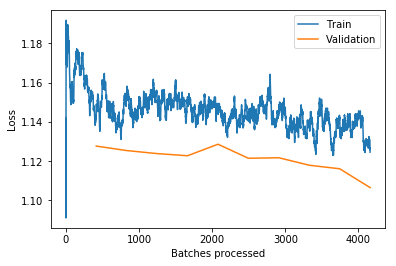

In [ ]:
learn.recorder.plot_losses()

In [ ]:
x,y,preds = get_preds()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


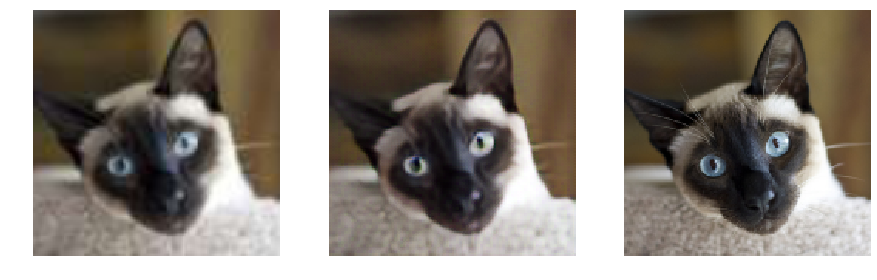

In [ ]:
#160
show_pred(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


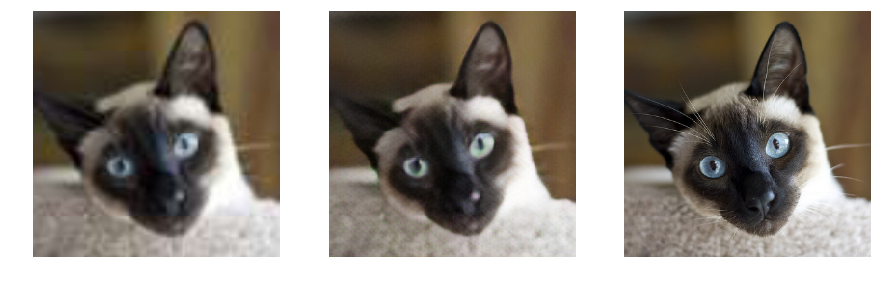

In [ ]:
#256
show_pred(0)

In [ ]:
learn.save('1')

In [ ]:
learn.save('1b')

In [ ]:
learn.unfreeze()

In [ ]:
max_lr = learn.lr_range(slice(1,100))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


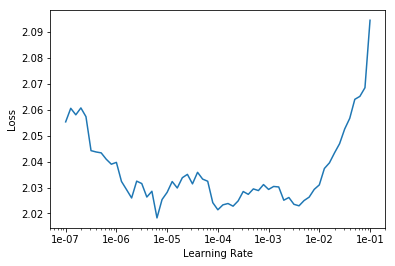

In [ ]:
learn.lr_find(max_lr*1e-10,max_lr)
learn.recorder.plot()

In [ ]:
lrs = slice(1e-5,1e-3)

In [ ]:
#160
learn.fit_one_cycle(10, lrs)

Total time: 12:55
epoch  train_loss  valid_loss  L1        edge      feat_0    feat_1    feat_2  
1      1.252074    1.169677    0.143425  0.222143  0.230828  0.099806  0.473475  (01:17)
2      1.256245    1.170008    0.144272  0.222112  0.231050  0.099885  0.472690  (01:17)
3      1.241893    1.161309    0.140689  0.221839  0.229829  0.099370  0.469582  (01:17)
4      1.250864    1.157366    0.141072  0.221515  0.229322  0.098811  0.466646  (01:17)
5      1.244328    1.159456    0.146212  0.221158  0.228512  0.098606  0.464969  (01:17)
6      1.248360    1.156611    0.146866  0.220871  0.228319  0.097996  0.462559  (01:17)
7      1.236795    1.146795    0.140265  0.220682  0.227530  0.097794  0.460526  (01:17)
8      1.236677    1.151178    0.145877  0.220690  0.227635  0.097639  0.459337  (01:17)
9      1.229775    1.148504    0.144443  0.220496  0.227248  0.097468  0.458849  (01:17)
10     1.234752    1.143077    0.139048  0.220519  0.227180  0.097463  0.458868  (01:16)



In [ ]:
#256
learn.fit_one_cycle(10, lrs)

Total time: 30:54
epoch  train_loss  valid_loss  L1        edge      feat_0    feat_1    feat_2  
1      1.121601    1.108021    0.163671  0.240827  0.239943  0.095099  0.368481  (03:05)
2      1.152219    1.107916    0.163057  0.240677  0.240356  0.095430  0.368396  (03:05)
3      1.134238    1.114626    0.167246  0.241291  0.240591  0.095775  0.369723  (03:05)
4      1.131768    1.111849    0.168286  0.240471  0.240313  0.095189  0.367591  (03:05)
5      1.116033    1.103808    0.163124  0.240271  0.239947  0.095065  0.365402  (03:05)
6      1.127988    1.103848    0.164868  0.240258  0.238469  0.094734  0.365519  (03:05)
7      1.115314    1.097744    0.162238  0.239720  0.238238  0.094257  0.363291  (03:05)
8      1.119037    1.103550    0.168734  0.239946  0.237993  0.094033  0.362845  (03:05)
9      1.106170    1.099159    0.165481  0.239733  0.237623  0.093946  0.362375  (03:06)
10     1.109046    1.096642    0.162915  0.239775  0.237625  0.093946  0.362381  (03:05)



In [ ]:
learn.save('2');

In [ ]:
learn.save('2b');

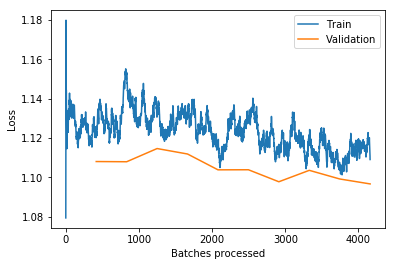

In [ ]:
learn.recorder.plot_losses()

## Test

In [ ]:
learn.load('2b');

In [ ]:
x,y,preds = get_preds()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


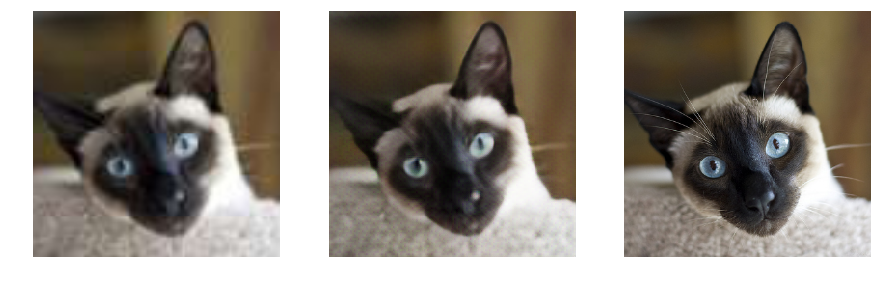

In [ ]:
show_pred(0)

In [ ]:
data_mr = (src.label_from_func(lambda x: path_mr/x.name)
          .transform(get_transforms(max_zoom=2.), size=(820,1024), tfm_y=True)
          .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

learn.data = data_mr

In [ ]:
img = open_image(data_mr.valid_ds.y.items[0])

In [ ]:
_,img_hr,b = learn.predict(img)

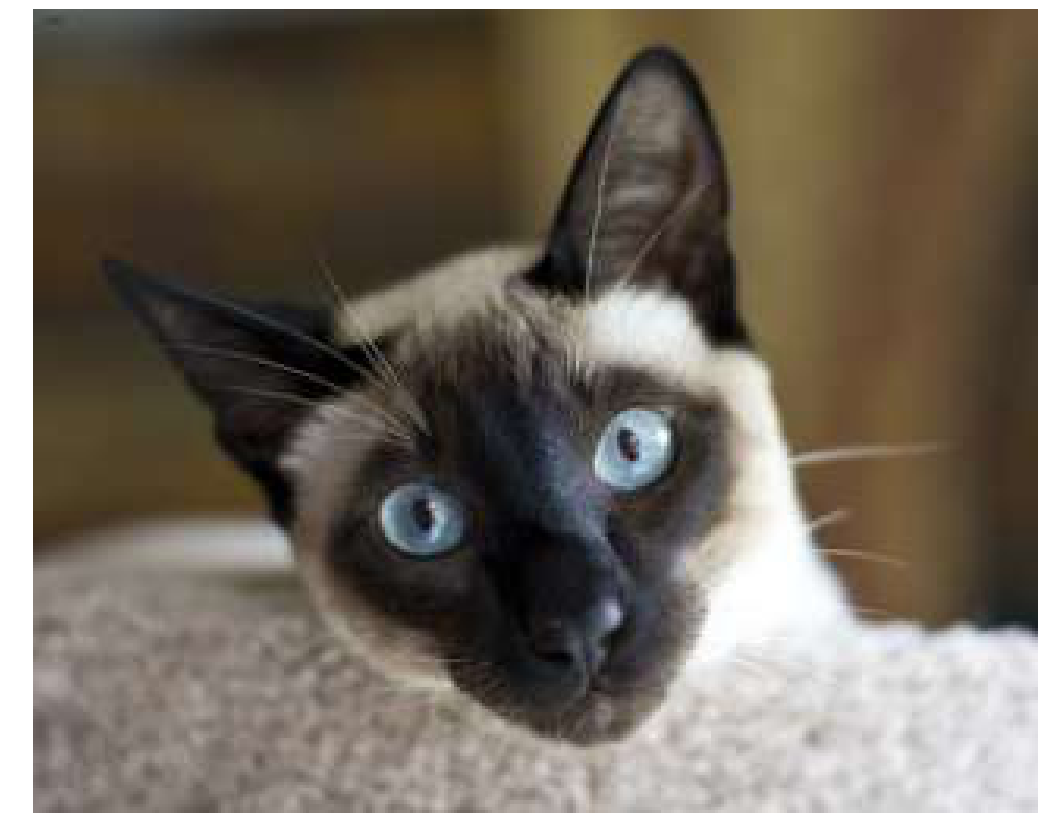

In [ ]:
img.show(figsize=(18,15))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


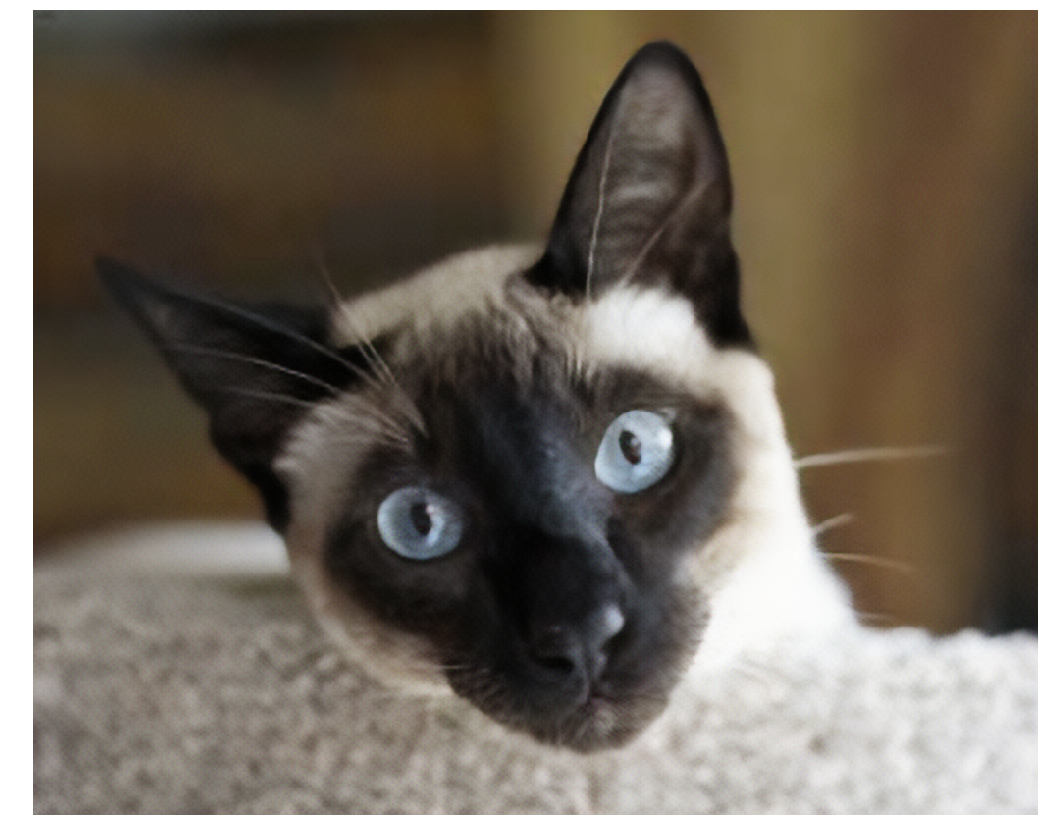

In [ ]:
Image(img_hr).show(figsize=(18,15))